# Partial dependence plots

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

import numpy as np
import xarray as xr
import pickle

2.1.0


In [2]:
tf.random.set_seed(1234)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)

In [4]:
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
import sklearn
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import string

In [7]:
!ls saved_model_v9/

accretion_01_LcLrXcXrNu_sigm_16x16x16_big_n5
accretion_01_LcLrXcXrNu_sigm_16x16x16_big_n5_norm.pickle
accretion_01_LcLrXcXr_sigm_16x16x16_big_n5
accretion_01_LcLrXcXr_sigm_16x16x16_big_n5_norm.pickle
accretion_01_LcLrXc_sigm_16x16x16_big_n5
accretion_01_LcLrXc_sigm_16x16x16_big_n5_norm.pickle
accretion_01_LcLr_sigm_16x16x16_big_n5
accretion_01_LcLr_sigm_16x16x16_big_n5_norm.pickle
accretion_withN_01_LcLrXcXrNu_ReLU_deep_big_n5
accretion_withN_01_LcLrXcXrNu_ReLU_deep_big_n5_norm.pickle
accretion_withN_01_LcLrXcXrNu_sigm_16x16x16_big_n5
accretion_withN_01_LcLrXcXrNu_sigm_16x16x16_big_n5_norm.pickle
accretion_withN_01_LcLrXcXr_ReLU_deep_big_n5
accretion_withN_01_LcLrXcXr_ReLU_deep_big_n5_norm.pickle
accretion_withN_01_LcLrXcXr_sigm_16x16x16_big_n5
accretion_withN_01_LcLrXcXr_sigm_16x16x16_big_n5_norm.pickle
accretion_withN_01_LcLrXc_ReLU_deep_big_n5
accretion_withN_01_LcLrXc_ReLU_deep_big_n5_norm.pickle
accretion_withN_01_LcLrXc_sigm_16x16x16_big_n5
accretion_withN_01_LcLrXc_sigm_16x16x16

## Accretion

In [8]:
keras_model = keras.models.load_model('saved_model_v9/accretion_01_LcLrXcXrNu_sigm_16x16x16_big_n5/')

In [11]:
normed_train_data = pd.read_csv('saved_model_v9/accretion_01_normed_train_data3.csv')
normed_val_data = pd.read_csv('saved_model_v9/accretion_01_normed_val_data3.csv')
normed_test_data = pd.read_csv('saved_model_v9/accretion_01_normed_test_data3.csv')
train_labels = pd.read_csv('saved_model_v9/accretion_01_train_labels3.csv')
val_labels = pd.read_csv('saved_model_v9/accretion_01_val_labels3.csv')
test_labels = pd.read_csv('saved_model_v9/accretion_01_test_labels3.csv')

In [12]:
cols_acc = list(normed_test_data.columns)

In [13]:
with open('saved_model_v9/accretion_01_LcLrXcXrNu_sigm_16x16x16_big_n5_norm.pickle', 'rb') as f:
    norm_acc = pickle.load(f)

In [14]:
def make_model():
    model = keras_model
    model.compile(keras.optimizers.SGD(0.), 'mse')
    return model

In [15]:
def compute_pdp(keras_model, normed_test_data):
    def make_model():
        model = keras_model
        model.compile(keras.optimizers.SGD(0.), 'mse')
        return model
    est = KerasRegressor(make_model)
    # Necessary for some dumb reason
    est.fit(normed_test_data[:2].values, np.ones((2, 1)))
    est._estimator_type = 'regressor'
    est.dummy_ = 'stupid'
    pdps = []
    vals = []
    for feature in normed_test_data:
        pdp, v = partial_dependence(est, normed_test_data[::20], feature, grid_resolution=100)
        pdps.append(pdp[0]); vals.append(v[0])
    return pdps, vals

In [16]:
def plot_pdp(pdps, vals, norm, ylabel, samey=False, exp=False, axs=None):
    if exp:
        miny = np.min([np.min(np.exp(pdp)) for pdp in pdps]); maxy = np.max([np.max(np.exp(pdp)) for pdp in pdps])
        miny = 0.5*miny; maxy=1.5*maxy
    else:
        miny = np.min([np.min(pdp) for pdp in pdps]); maxy = np.max([np.max(pdp) for pdp in pdps])
    if axs is None: fig, axs = plt.subplots(1, 5, figsize=(10, 2.3))
    for i, (pdp, v, ax, f) in enumerate(zip(pdps, vals, axs, normed_test_data.columns)):
        vv = v * norm.T[f]['std'] + norm.T[f]['mean']
        if exp: 
            if f != 'nu':
                vv = np.exp(vv)
            pdp = np.exp(pdp)
        ax.plot(vv, pdp, lw=2.5, c='navy')
        ax.set_xlabel(f)
        ax.set_title(f'{string.ascii_lowercase[i]})')
        if samey: ax.set_ylim(miny, maxy)
        if exp: 
            ax.set_xscale('log')
            ax.set_yscale('log')
    axs[0].set_ylabel(ylabel)
    if axs is None: plt.tight_layout(w_pad=0.8)
    return axs

In [17]:
pdps_acc, vals_acc = compute_pdp(keras_model, normed_test_data)

Train on 2 samples
2/2 [==============================] - 1s 437ms/sample - loss: 1177.0811


In [18]:
def acc_sb2001(Lc, Lr, use_phi=False):
    kr = 5.78
    tau = Lc/(Lc+Lr)
    if use_phi:
        phi = (tau/(tau+5e-4))**4
    else:
        phi = 1.
    acc = kr*Lc*Lr*phi
    return acc

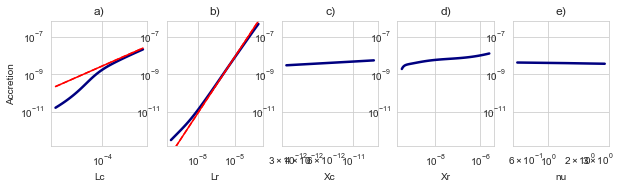

In [29]:
axs = plot_pdp(pdps_acc, vals_acc, norm_acc, 'Accretion', samey=True, exp=True)
v=vals_acc[0]; f='Lc'
vv = v * norm_acc.T[f]['std'] + norm_acc.T[f]['mean']
vv = np.exp(vv)
acc = acc_sb2001(vv, np.exp(norm_acc['mean']['Lr']), True)
axs[0].plot(vv, acc, c='r')
acc = acc_sb2001(vv, np.exp(norm_acc['mean']['Lr']))
axs[0].plot(vv, acc, c='r', ls='--')
v=vals_acc[1]; f='Lr'
vv = v * norm_acc.T[f]['std'] + norm_acc.T[f]['mean']
vv = np.exp(vv)
acc = acc_sb2001(np.exp(norm_acc['mean']['Lc']), vv, True)
axs[1].plot(vv, acc, c='r');
acc = acc_sb2001(np.exp(norm_acc['mean']['Lc']), vv)
axs[1].plot(vv, acc, c='r', ls='--');

## Autocon

In [30]:
keras_model = keras.models.load_model('saved_model_v9/autocon_LcXcNuTau_01_sigm_16x16x16_big_n5_z12/')

In [32]:
normed_test_data = pd.read_csv('saved_model_v9/autocon_01_normed_test_data3.csv')
test_labels = pd.read_csv('saved_model_v9/autocon_01_test_labels3.csv')

In [33]:
cols_au = list(normed_test_data.columns)

In [34]:
with open('saved_model_v9/autocon_LcXcNuTau_01_sigm_16x16x16_big_n5_z12_norm.pickle', 'rb') as f:
    norm_au = pickle.load(f)

In [35]:
pdps_au, vals_au = compute_pdp(keras_model, normed_test_data)

Train on 2 samples
2/2 [==============================] - 0s 126ms/sample - loss: 783.3406


In [36]:
def au_sb2001(Lc, Xc, tau, nu):
    kc = 9.44e9
    xstar = 2.6e-10
    phi = 600*tau**0.68*(1-tau**0.68)**3
    au = kc/20/xstar * (nu+2) * (nu+4) / (nu+1)**2 *Lc**2 * Xc**2 * (1+phi/(1-tau)**2)
    return au

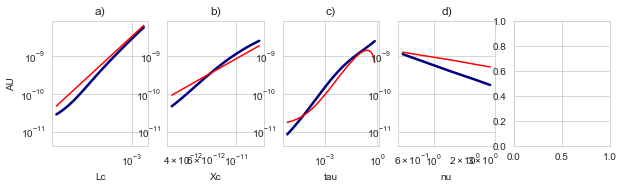

In [38]:
axs = plot_pdp(pdps_au, vals_au, norm_au, 'AU', samey=True, exp=True)

v=vals_au[0]; f='Lc'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(vv, np.exp(norm_au['mean']['Xc']), np.exp(norm_au['mean']['tau']), np.exp(norm_au['mean']['nu']))
axs[0].plot(vv, au, c='r')

v=vals_au[1]; f='Xc'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(np.exp(norm_au['mean']['Lc']), vv, np.exp(norm_au['mean']['tau']), np.exp(norm_au['mean']['nu']))
axs[1].plot(vv, au, c='r')

v=vals_au[2]; f='tau'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(np.exp(norm_au['mean']['Lc']), np.exp(norm_au['mean']['Xc']), vv, np.exp(norm_au['mean']['nu']))
axs[2].plot(vv, au, c='r')

v=vals_au[3]; f='nu'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
au = au_sb2001(np.exp(norm_au['mean']['Lc']), np.exp(norm_au['mean']['Xc']), np.exp(norm_au['mean']['tau']), vv)
axs[3].plot(vv, au, c='r')

## Selfcloud

In [39]:
keras_model = keras.models.load_model('saved_model_v9/selfcloud_01_LcXcNuTau_sigm_16x16x16_big_n5/')

In [40]:
normed_test_data = pd.read_csv('saved_model_v9/selfcloud_01_normed_test_data4.csv')
test_labels = pd.read_csv('saved_model_v9/selfcloud_01_test_labels4.csv')

In [41]:
cols_scc = list(normed_test_data.columns)

In [42]:
with open('saved_model_v9/selfcloud_01_LcXcNuTau_sigm_16x16x16_big_n5_norm.pickle', 'rb') as f:
    norm_scc = pickle.load(f)

In [43]:
pdps_scc, vals_scc = compute_pdp(keras_model, normed_test_data)

Train on 2 samples
2/2 [==============================] - 0s 127ms/sample - loss: 31.9419


In [44]:
def scc_sb2001(Lc, nu):
    kc = 9.44e9
    scc = kc * (nu+2) / (nu+1) * Lc**2
    return scc

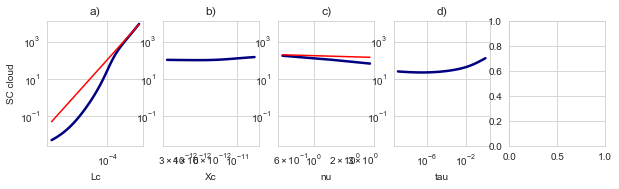

In [46]:
axs = plot_pdp(pdps_scc, vals_scc, norm_scc, 'SC cloud', samey=True, exp=True)
v=vals_scc[0]; f='Lc'
vv = v * norm_scc.T[f]['std'] + norm_scc.T[f]['mean']
vv = np.exp(vv)
scc = scc_sb2001(vv, np.exp(norm_scc['mean']['nu']))
axs[0].plot(vv, scc, c='r')


v=vals_scc[2]; f='nu'
vv = v * norm_scc.T[f]['std'] + norm_scc.T[f]['mean']
scc = scc_sb2001(np.exp(norm_scc['mean']['Lc']), vv)
axs[2].plot(vv, scc, c='r');



## Selfrain

In [47]:
keras_model = keras.models.load_model('saved_model_v9/selfrain_01_LrXr_sigm_16x16x16_big_n5/')

In [48]:
normed_test_data = pd.read_csv('saved_model_v9/selfrain_01_normed_test_data1.csv')
test_labels = pd.read_csv('saved_model_v9/selfrain_01_test_labels1.csv')

In [49]:
cols_scr = list(normed_test_data.columns)

In [50]:
with open('saved_model_v9/selfrain_01_LrXr_sigm_16x16x16_big_n5_norm.pickle', 'rb') as f:
    norm_scr = pickle.load(f)

In [51]:
pdps_scr, vals_scr = compute_pdp(keras_model, normed_test_data)

Train on 2 samples
2/2 [==============================] - 0s 133ms/sample - loss: 262.7549


In [52]:
def scr_sb2001(Lr, Xr):
    kr = 5.78
    sc = kr*Lr**2/Xr
    return sc

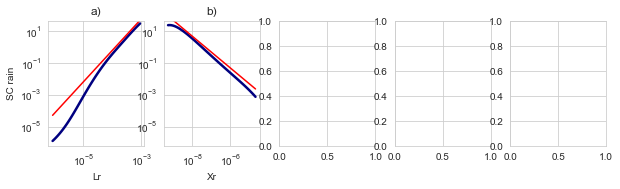

In [55]:
axs = plot_pdp(pdps_scr, vals_scr, norm_scr, 'SC rain', samey=True, exp=True)
v=vals_scr[0]; f='Lr'
vv = v * norm_scr.T[f]['std'] + norm_scr.T[f]['mean']
vv = np.exp(vv)
sc = scr_sb2001(vv, np.exp(norm_scr['mean']['Xr']))
axs[0].plot(vv, sc, c='r')
v=vals_scr[1]; f='Xr'
vv = v * norm_scr.T[f]['std'] + norm_scr.T[f]['mean']
vv = np.exp(vv)
sc = scr_sb2001(np.exp(norm_scr['mean']['Lr']), vv)
axs[1].plot(vv, sc, c='r');

## Final figure

In [56]:
def plot_pdp(pdps, vals, norm, ylabel=None, samey=False, exp=False, axs=None):
    if exp:
        miny = np.min([np.min(np.exp(pdp)) for pdp in pdps]); maxy = np.max([np.max(np.exp(pdp)) for pdp in pdps])
        miny = 0.5*miny; maxy=1.5*maxy
    else:
        miny = np.min([np.min(pdp) for pdp in pdps]); maxy = np.max([np.max(pdp) for pdp in pdps])
    if axs is None: fig, axs = plt.subplots(1, 5, figsize=(10, 2.3))
    for i, (pdp, v, ax, f) in enumerate(zip(pdps, vals, axs, norm.T.columns)):
        vv = v * norm.T[f]['std'] + norm.T[f]['mean']
        if exp: 
            if f != 'nu':
                vv = np.exp(vv)
            pdp = np.exp(pdp)
        ax.plot(vv, pdp, lw=4, c='navy', label='Neural network')
#         ax.set_xlabel(f)
#         ax.set_title(f'{string.ascii_lowercase[i]})')
        if samey: ax.set_ylim(miny, maxy)
        if exp: 
            if f != 'nu':
                ax.set_xscale('log')
            ax.set_yscale('log')
    if ylabel is not None: axs[0].set_ylabel(ylabel)
    if axs is None: plt.tight_layout(w_pad=0.8)
    return axs

In [57]:
cols_acc

['Lc', 'Lr', 'Xc', 'Xr', 'nu']

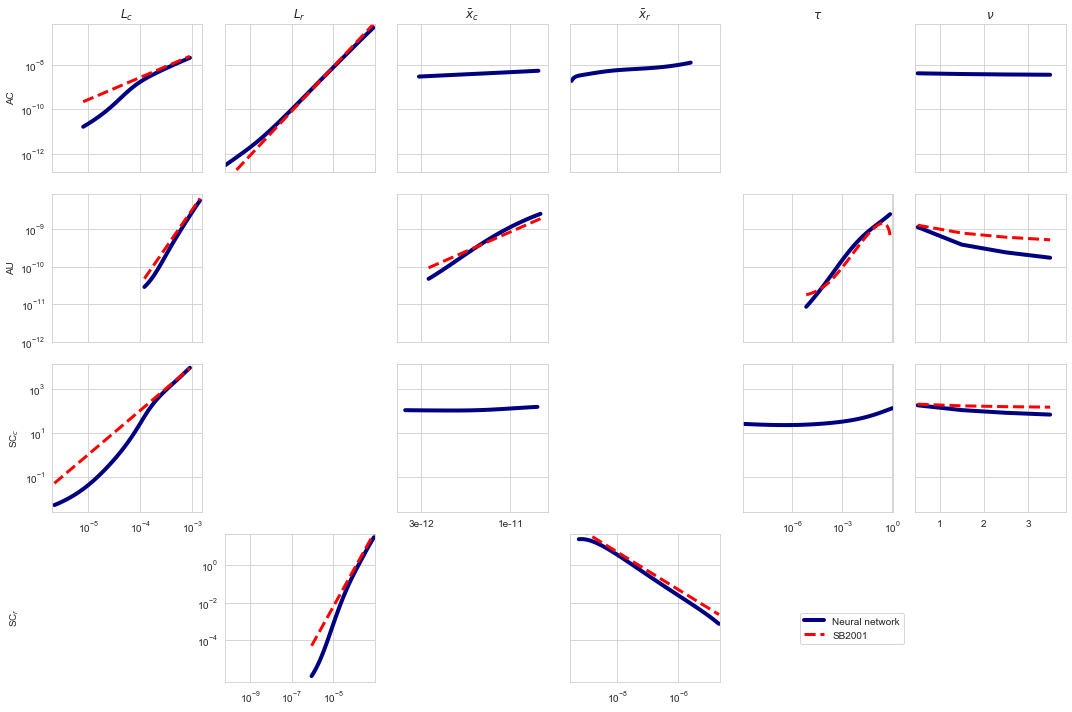

In [70]:
fig, axs = plt.subplots(4, 6, figsize=(15, 10))

col_order =['Lc', 'Lr', 'Xc', 'Xr', 'tau', 'nu']
col_names =[r'$L_c$', r'$L_r$', r'$\bar{x}_c$', r'$\bar{x}_r$', r'$\tau$', r'$\nu$']

# Accretion
axx = [axs[0, col_order.index(v)] for v in cols_acc]
[ax.axis('off') for v, ax in zip(col_order, axs[0]) if v not in cols_acc]

plot_pdp(pdps_acc, vals_acc, norm_acc, samey=True, exp=True, axs=axx)
    
v=vals_acc[0]; f='Lc'
vv = v * norm_acc.T[f]['std'] + norm_acc.T[f]['mean']
vv = np.exp(vv)
acc = acc_sb2001(vv, np.exp(norm_acc['mean']['Lr']), True)
axx[0].plot(vv, acc, c='r', lw=3, ls='--')
# acc = acc_sb2001(vv, np.exp(norm_acc['mean']['Lr']))
# axx[0].plot(vv, acc, c='r', ls='--', lw=3, ls='--')
v=vals_acc[1]; f='Lr'
vv = v * norm_acc.T[f]['std'] + norm_acc.T[f]['mean']
vv = np.exp(vv)
acc = acc_sb2001(np.exp(norm_acc['mean']['Lc']), vv, True)
axx[1].plot(vv, acc, c='r', lw=3, ls='--');
# acc = acc_sb2001(np.exp(norm_acc['mean']['Lc']), vv)
# axx[1].plot(vv, acc, c='r', ls='--', lw=3, ls='--');


# Autoconversion
axx = [axs[1, col_order.index(v)] for v in cols_au]
[ax.axis('off') for v, ax in zip(col_order, axs[1]) if v not in cols_au]

plot_pdp(pdps_au, vals_au, norm_au, samey=True, exp=True, axs=axx)

v=vals_au[0]; f='Lc'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(vv, np.exp(norm_au['mean']['Xc']), np.exp(norm_au['mean']['tau']), np.exp(norm_au['mean']['nu']))
axx[0].plot(vv, au, c='r', lw=3, ls='--')

v=vals_au[1]; f='Xc'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(np.exp(norm_au['mean']['Lc']), vv, np.exp(norm_au['mean']['tau']), np.exp(norm_au['mean']['nu']))
axx[1].plot(vv, au, c='r', lw=3, ls='--')

v=vals_au[2]; f='tau'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(np.exp(norm_au['mean']['Lc']), np.exp(norm_au['mean']['Xc']), vv, np.exp(norm_au['mean']['nu']))
axx[2].plot(vv, au, c='r', lw=3, ls='--')

v=vals_au[3]; f='nu'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
au = au_sb2001(np.exp(norm_au['mean']['Lc']), np.exp(norm_au['mean']['Xc']), np.exp(norm_au['mean']['tau']), vv)
axx[3].plot(vv, au, c='r', lw=3, ls='--')


# SC C
axx = [axs[2, col_order.index(v)] for v in cols_scc]
[ax.axis('off') for v, ax in zip(col_order, axs[2]) if v not in cols_scc]

plot_pdp(pdps_scc, vals_scc, norm_scc, samey=True, exp=True, axs=axx)

v=vals_scc[0]; f='Lc'
vv = v * norm_scc.T[f]['std'] + norm_scc.T[f]['mean']
vv = np.exp(vv)
scc = scc_sb2001(vv, np.exp(norm_scc['mean']['nu']))
axx[0].plot(vv, scc, c='r', lw=3, ls='--')

v=vals_scc[2]; f='nu'
vv = v * norm_scc.T[f]['std'] + norm_scc.T[f]['mean']
scc = scc_sb2001(np.exp(norm_scc['mean']['Lc']), vv)
axx[2].plot(vv, scc, c='r', lw=3, ls='--');



# SC R
axx = [axs[3, col_order.index(v)] for v in cols_scr]
[ax.axis('off') for v, ax in zip(col_order, axs[3]) if v not in cols_scr]

plot_pdp(pdps_scr, vals_scr, norm_scr, samey=True, exp=True, axs=axx)

v=vals_scr[0]; f='Lr'
vv = v * norm_scr.T[f]['std'] + norm_scr.T[f]['mean']
vv = np.exp(vv)
sc = scr_sb2001(vv, np.exp(norm_scr['mean']['Xr']))
axx[0].plot(vv, sc, c='r', lw=3, ls='--')

v=vals_scr[1]; f='Xr'
vv = v * norm_scr.T[f]['std'] + norm_scr.T[f]['mean']
vv = np.exp(vv)
sc = scr_sb2001(np.exp(norm_scr['mean']['Lr']), vv)
axx[1].plot(vv, sc, c='r', lw=3, ls='--', label='SB2001');

[ax.set_title(c) for ax, c in zip(axs[0], col_names)]
[ax.set_ylabel(v) for ax, v in zip(axs[:, 0], [r'AC', r'AU', r'SC$_c$', r'SC$_r$'])]

plt.tight_layout()

for i, v in enumerate(col_order):
    minx = []; maxx = []
    for c, val, norm in zip(
        [cols_acc, cols_au, cols_scc, cols_scr], 
        [vals_acc, vals_au, vals_scc, vals_scr],
        [norm_acc, norm_au, norm_scc, norm_scr]
    ):
        try:
            idx = c.index(v)
            vv = val[idx] * norm.T[v]['std'] + norm.T[v]['mean']
#             print(vv)
            if not v == 'nu':
                vv = np.exp(vv)
#             print(vv)
            minx.append(np.min(vv)); maxx.append(np.max(vv))
        except:
            pass
    minx = np.min(minx)*0.9; maxx = np.max(maxx)*1.1
#     print(v, minx, maxx)
    
    [ax.set_xlim(minx, maxx) for ax in axs[:, i]]
    
#Ticks

[ax.set_xticks([1e-5, 1e-4, 1e-3]) for ax in axs[:, 0]]
[ax.set_xticks([1e-9, 1e-7, 1e-5]) for ax in axs[:, 1]]
[ax.set_xticks([1e-8, 1e-6]) for ax in axs[:, 3]]
[ax.set_xticks([1e-6, 1e-3, 1e-0]) for ax in axs[:, 4]]
[ax.set_xticks([1, 2, 3]) for ax in axs[:, 5]]

[ax.set_yticks([1e-8, 1e-10, 1e-12]) for ax in axs[0]]
[ax.set_yticks([1e-9, 1e-10, 1e-11, 1e-12]) for ax in axs[1]]
[ax.set_yticks([1e3, 1e1, 1e-1]) for ax in axs[2]]
[ax.set_yticks([1e0, 1e-2, 1e-4]) for ax in axs[3]]
    

[ax.set_xticks([], minor=True) for ax in axs[:, 2]]
[ax.set_xticks([3e-12, 1e-11], minor=False) for ax in axs[:, 2]]
[ax.set_xticklabels([3e-12, 1e-11]) for ax in axs[:, 2]]

[ax.set_xticklabels([]) for ax in np.concatenate([
    axs[0], axs[1]
])]
[ax.set_yticklabels([]) for ax in np.concatenate([
    axs[:, 2:].flat, axs[:3, 1]
])]
plt.subplots_adjust(wspace=0.15, hspace=0.15)

axs[3, 3].legend(bbox_to_anchor=(1.5, 0.5))

axs[-1, 0].text(-.00045, 0.4, r'SC$_r$', rotation=90)

fig.savefig('PDP.pdf', bbox_inches='tight')

In [62]:
#ax.text()

In [63]:
v = 'Lc'

In [64]:
cols_scr.index(v)

ValueError: 'Lc' is not in list

In [ ]:
minx = []; maxx = []
for c, val in zip([cols_acc, cols_au, cols_scc, cols_scr], [vals_acc, vals_au, vals_scc, vals_scr]):
    try:
        idx = c.index(v)
        vv = val[idx]
        if not v == 'nu':
            vv = np.exp(vv)
        minx.append(np.min(vv)); maxx.append(np.max(vv))
    except:
        pass

In [ ]:
col_order

In [ ]:
cols_acc, cols_au, cols_scc, cols_scr

## To save in other notebooks

In [ ]:
# Save data for PDP notebook
normed_train_data3.to_csv('accretion_01_normed_train_data3.csv', index=False)
normed_val_data3.to_csv('accretion_01_normed_val_data3.csv', index=False)
normed_test_data3.to_csv('accretion_01_normed_test_data3.csv', index=False)
train_labels3.to_csv('accretion_01_train_labels3.csv', index=False)
val_labels3.to_csv('accretion_01_val_labels3.csv', index=False)
test_labels3.to_csv('accretion_01_test_labels3.csv', index=False)